# Cell Tracking (Project 6)

**Group 12: Maximilian Karhausen, Johannes Simon**

**Background:** When testing a pharmacological drug onto cells, the effect on the cell population growth and 
overall phenotype is usually assessed by a single snapshot image. While these population and 
time-averaged measurements can highlight big scale effects between cell populations and 
conditions, they are an indirect measure of responses to chemotherapeutic drugs. Another 
approach is to record long videos of these cell populations while subjected to the drugs. These 
live observations are more accurate in capturing the proliferation behavior than standard 
approaches. Manual tracking of each single cell in the visual field is very time-consuming.

**Approach:** Given pre-detected cancer cells (in COCO format), we investigate suitable methods to match detections across frames (tracking). To do this, we compare the tracking methods SORT and DeepSORT with each other.

In [178]:
# Get all necessary imports
import cv2
import json
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import motmetrics as mm
import numpy as np
import random
import torch

from pathlib import Path
from PIL import Image

In [5]:
torch.cuda.is_available()

True

## Part 1: Load the dataset and classify the cells

In [8]:
# Initialize local paths
# Dataset path
# Hint: (change to "/scratch/cv-course/jsimon10/dataset_jpg/dataset" when working on RAMSES)
DATASET_DIR = Path("dataset_jpg/dataset")
# Annotations file path
ANN_FILE = DATASET_DIR / "annotations.json"
# Create folder for cropped cells, needed later to train appearance model for DeepSORT
CROP_DIR = Path("cell_crops")
CROP_DIR.mkdir(exist_ok=True)

In [10]:
# Load the COCO annotations from the annotations.json file
with ANN_FILE.open("r") as f:
    coco = json.load(f)
# Get category name by their ID
cat_name_by_id = {cat["id"]: cat["name"] for cat in coco["categories"]}
# Group all annotations by their image ID to find all cells for each image more easily
annots_by_img = {}
for ann in coco["annotations"]:
    annots_by_img.setdefault(ann["image_id"], []).append(ann)
# Group all images by their ID to find them more faster
img_by_id = {}
for img in coco["images"]:
    img_by_id[img["id"]] = img
# Print summary info on the dataset once loaded
print("Loaded dataset with:")
print(f"  - {len(coco['images'])} images")
print(f"  - {len(coco['annotations'])} annotations")
print(f"  - {len(coco['categories'])} categories:")
for cat_id, cat_name in cat_name_by_id.items():
    print(f"    ID {cat_id}: {cat_name}")

Loaded dataset with:
  - 40350 images
  - 2204912 annotations
  - 2 categories:
    ID 1: living_cell
    ID 2: dead_cell


In [152]:
# Extract special events (cell division and death) for visualization later as (video_name, event_frame_id, cell_id, 'division'/'death')
events = []
# Group all video IDs by their name to find them more easily
video_id_by_name = {v["id"]: v["name"] for v in coco["videos"]}
# Loop through annotations to find all cell divisions and deaths
for ann in coco["annotations"]:
    vid = ann["video_id"]
    vid_name = video_id_by_name[vid]
    time_div = ann.get("time_of_division")
    # Add the frame where a cell divides to special events
    if time_div is not None:
        events.append((vid_name, int(time_div), ann["cell_id"], "division"))
    time_death = ann.get("time_of_death")
    # Add the frame where a cell dies to special events
    if time_death is not None:
        events.append((vid_name, int(time_death), ann["cell_id"], "death"))

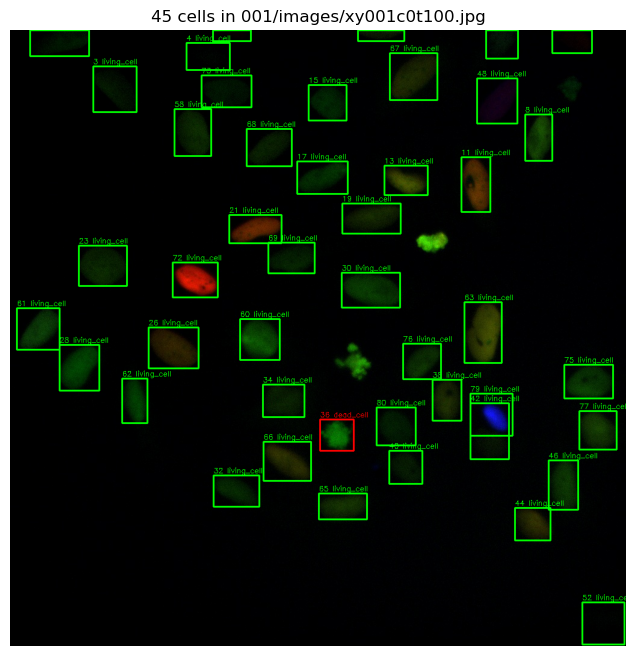

In [180]:
# Get an image by an selected index for visualization
img_example = img_by_id[100] # For testing, only index of 0-449 works. Original dataset: up to 40349
# Get the path to the image
img_path = DATASET_DIR / img_example["file_name"]
# Raise an error if image does not exist
if not img_path.exists():
    raise FileNotFoundError(f"Image file not found: {img_path}")
# Load the image and turn from BGR to RGB
img_rgb = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
# Get annotations for the selected image
annots = annots_by_img.get(img_example["id"], [])
# Apply different colors for bounding boxes of different classes
bbox_color_map = {
    "living_cell": (0, 255, 0),     # green for living cell
    "dead_cell": (255, 0, 0),     # red for dead cell
}
# Draw bounding boxes based on annotations
for i, ann in enumerate(annots):
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # For correct drawing (and SORT later), convert center-based x and y coordinates to top-left
    x, y = x_center - width / 2, y_center - height / 2
    # For correct drawing, turn float values to int values - OpenCV expects int values
    x_draw, y_draw, width_draw, height_draw = int(x), int(y), int(width), int(height)
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Construct label with cell ID and category name, e.g. 30 living_cell
    label = f"{ann['cell_id']} {cat_name}"
    # Get the respective color of bounding box
    color = bbox_color_map.get(cat_name, (255, 255, 255)) # Edge case: If annotation without category exist, color white
    # Draw the bounding boxes and the text with the classified category 
    cv2.rectangle(img_rgb, (x_draw, y_draw), (x_draw + width_draw, y_draw + height_draw), color, 2)
    cv2.putText(img_rgb, label, (x_draw, y_draw - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
# Show classification result
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{len(annots)} cells in {img_example['file_name']}")
plt.show()

## Part 2: Prepare the data for DeepSORT

In [64]:
# Get all folder names in a sorted list
#all_folders = sorted([f.name for f in DATASET_DIR.iterdir() if f.is_dir()])
all_folders = ["001", "002", "003"] # REMOVE THIS FOR ORIGINAL DATASET
# Ensure reproducibility with same sequence of random folders
random.seed(30)
# Shuffle the list of folders randomly
random.shuffle(all_folders)
# Split the folders by 80% for training (with cropped cells) and 20% testing (for tracking)
split_idx = int(0.8 * len(all_folders))
train_folders = set(all_folders[:split_idx])
test_folders = set(all_folders[split_idx:])

In [17]:
# Crop cells for all annotations
for ann in coco["annotations"]:
    # Get image from current annotation
    img = img_by_id[ann["image_id"]]
    # Get image path of given image
    img_path = DATASET_DIR / img["file_name"]
    # Get ID of folder, e.g. 001
    folder = Path(img["file_name"]).parts[0]
    # Skip folders that are not selected for training
    if folder not in train_folders:
        continue
    # Load the image in BGR format
    img_bgr = cv2.imread(str(img_path))
    # Get center x and y coordinates of the bounding box with width and height
    x_center, y_center, width, height = ann["bbox"]
    # Get image bounds of the cell
    x0, y0, x1, y1 = int(x_center - width / 2), int(y_center - height / 2), int(x_center + width / 2), int(y_center + height / 2)
    # Get actual height and width of the original image
    img_height, img_width = img_bgr.shape[:2]
    # Skip all edge-cut cells
    if (x0 <= 0 or y0 <= 0 or x1 >= img_width or y1 >= img_height):
        continue
    # Define unique ID as video ID and cell ID for folder, e.g. 001_001
    id = f"{ann['video_id']:03d}_{ann['cell_id']:03d}"
    # Get the classified category
    cat_id = ann["category_id"]
    # Get the respective category name
    cat_name = cat_name_by_id.get(cat_id, "unknown") # Edge case: If annotation without category exist, label as "unknown"
    # Create folder for given cell ID by video ID to save cropped cells
    output_dir = CROP_DIR / id
    output_dir.mkdir(parents=True, exist_ok=True)
    # Save cropped cell with annotation ID and classified category, e.g. 0000002_living_cell.jpg
    output_img_name = f"{ann['id']:07d}_{cat_name}.jpg"
    # Specify path of cropped cell image
    output_img_path = output_dir / output_img_name
    # Crop the original image to constructed bounding box with the cell and write it to given path
    cv2.imwrite(str(output_img_path), img_bgr[y0:y1, x0:x1])
print("Successfully cropped cells for training the appearance model of DeepSORT")

Successfully cropped cells for training the appearance model of DeepSORT


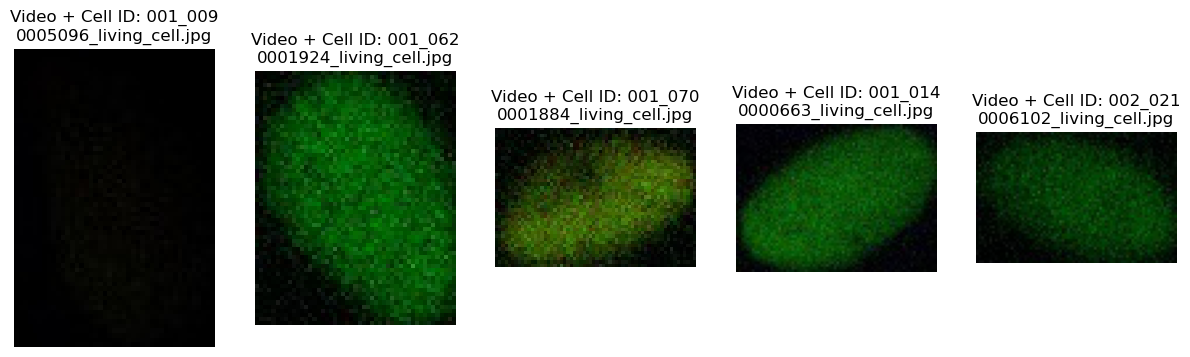

In [19]:
# Collect all cropped cell image paths
crop_paths = list(CROP_DIR.rglob("*.jpg"))
# Randomly pick five example images
crop_examples = random.sample(crop_paths, 5)
# Plot the five images
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(crop_examples):
    # Load the current image
    img = cv2.imread(str(img_path))
    # Turn the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Create five consecutive subplots
    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    # Print folder and image name
    plt.title("Video + Cell ID: " + img_path.parts[-2] + "\n" + img_path.name)
    plt.axis('off')
plt.show()

## Part 3: Train the appearance model of DeepSORT

In [22]:
# Initialize different values for hyperparameters for in-depth analysis
batch_sizes = [4, 8, 16, 32, 64] # Default: 32
lrs = [0.0001, 0.001, 0.01] # Default: 0.001
optimizer = ["sgd", "nesterov", "adam"] # Default: SGD

In [ ]:
# Train the appearance model through train.py of DeepSORT with different learning rates and optimizers
# Grid Search for two hyperparameters that interact strongly with each other; investigate impact of hyperparameters and find best performing pair
for lr in lrs:
    for opt in optimizer:
        print("---------------------------------------------------------------------------------")
        print(f"Appearance model with batch size: {32}, epochs: {40}, learning rate: {lr}, optimizer: {opt}")
        # Initialize model name for train.jpg
        model_name = f"{opt}_lr{lr}_batch{32}"
        # Train the model
        !python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --lr {lr} --optimizer {opt} --model_name {model_name}

In [24]:
# Manually select the best values for the learning rate and optimizer
best_lr = 0.001
best_opt = "sgd"

In [ ]:
# Train the appearance model through train.py of DeepSORT with different batch sizes
# Greedy Search for batch size with best performing learning rate + optimizer pair; investigate impact of batch size and find best performing one
for size in batch_sizes:
    print("---------------------------------------------------------------------------------")
    print(f"Appearance model with batch size: {size}, epochs: {40}, learning rate: {best_lr}, optimizer: {best_opt}")
    # Initialize model name for train.jpg
    model_name = f"{best_opt}_lr{best_lr}_batch{size}"
    # Train the model
    !python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --batch_size {size} --lr {best_lr} --optimizer {best_opt} --model_name {model_name}

In [26]:
# Manually select the best value for the batch size
best_batch_size = 32

In [34]:
# Train the final appearance model with the best performing hyperparameters
# Use 60 epochs, find optimal epoch count and use that model for tracking with DeepSORT
print(f"Final appearance model with batch size: {best_batch_size}, epochs: {60}, learning rate: {best_lr}, optimizer: {best_opt}")
# Initialize model name for train.jpg
model_name = f"final_version_{best_opt}_lr{best_lr}_batch{best_batch_size}"
# Train the model
!python deep_sort_pytorch/deep_sort/deep/train.py --data-dir cell_crops --epochs 60 --batch_size {best_batch_size} --lr {best_lr} --optimizer {best_opt} --model_name {model_name}

Final appearance model with batch size: 32, epochs: 40, learning rate: 0.001, optimizer: sgd
8849 images were found in the dataset.
7124 images for training.
1725 images for validation.
Using 8 dataloader workers every process
[epoch 0] train_loss: 4.367619514465332, train_acc: 0.059376754632229085, val_loss: 3.8700265884399414, val_acc: 0.13507246376811594
[epoch 1] train_loss: 3.841632843017578, train_acc: 0.10317237507018528, val_loss: 3.727018117904663, val_acc: 0.11420289855072464
[epoch 2] train_loss: 3.5504117012023926, train_acc: 0.14008983717012913, val_loss: 3.315913438796997, val_acc: 0.18028985507246376
[epoch 3] train_loss: 3.3104212284088135, train_acc: 0.17560359348680515, val_loss: 3.236686944961548, val_acc: 0.19652173913043477
[epoch 4] train_loss: 3.0801570415496826, train_acc: 0.2224873666479506, val_loss: 2.860478401184082, val_acc: 0.2707246376811594
[epoch 5] train_loss: 2.8760178089141846, train_acc: 0.27077484559236387, val_loss: 3.3240368366241455, val_acc: 0.

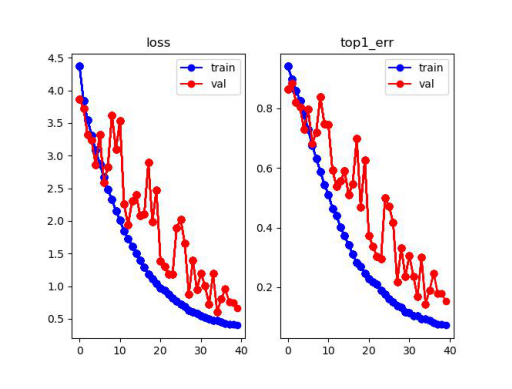

In [38]:
# Visualize the automatically generated train + val loss plot
train_val_img = mpimg.imread(f"train_final_version_{best_opt}_lr{best_lr}_batch{best_batch_size}.jpg")
plt.imshow(train_val_img)
plt.axis('off')
plt.show()

## Part 4: Track the cells with DeepSORT

In [138]:
# Get a list of all test frames (images)
all_test_frames = []
for vn in test_folders:
    imgs = [
        img for img in img_by_id.values()
        if img["file_name"].startswith(vn + "/")
    ]
    imgs.sort(key=lambda x: x["frame_id"])
    all_test_frames.extend(imgs)

In [148]:
def evaluate_all(acc, annots_by_img, all_test_frames, dets):
    """
    evaluate_all uses the tracking results as results.txt to evaluate the results with MOT metrics.

    :param acc: the MOTAccumulator required for using motmetrics
    :param annots_by_img: annotations grouped by their image ID
    :param all_test_frames: all frames from the test folder
    :param dets: a stacked array with tracklets from all results.txt files across the test folder
    
    :return: a summary DataFrame with evaluated MOT metrics on the whole test folder
    """ 
    # Group the list of tracklets by the frame they are on
    dets_by_frame = {}
    for r in dets:
        f, tid, x, y, w, h = r[:6].astype(int)
        dets_by_frame.setdefault(f, []).append((tid, x, y, w, h))
    # Loop through all the test frames
    for info in all_test_frames:
        fid = info["id"]
        fn = info["frame_id"]
        # Get the ground truth annotations for the test frames
        raw = annots_by_img.get(fid, [])
        gt_ids, gt_boxes = [], []
        for ann in raw:
            cid = ann["cell_id"]
            xc,yc,w_,h_ = ann["bbox"]
            x1,y1 = xc - w_/2, yc - h_/2
            gt_ids.append(cid)
            gt_boxes.append([x1, y1, x1 + w_, y1 + h_])
        # Get the prediction annotations for the test frames
        preds = dets_by_frame.get(fn, [])
        pred_ids  = [p[0] for p in preds]
        pred_boxes= [[p[1],p[2],p[1]+p[3],p[2]+p[4]] for p in preds]
        # Calculate the IoU distance as a cost matrix to determine how much GT boxes overlap with predicted boxes
        D = np.zeros((len(gt_boxes), len(pred_boxes)), dtype=float)
        for i, gb in enumerate(gt_boxes):
            for j, pb in enumerate(pred_boxes):
                xa, ya = max(gb[0], pb[0]), max(gb[1], pb[1])
                xb, yb = min(gb[2], pb[2]), min(gb[3], pb[3])
                inter = max(0, xb-xa)*max(0, yb-ya)
                ua = (gb[2]-gb[0])*(gb[3]-gb[1]) + \
                     (pb[2]-pb[0])*(pb[3]-pb[1]) - inter
                # Perfect match if IoU = 0 (instead of 1)
                iou = inter/ua if ua>0 else 0
                D[i,j] = 1 - iou
        acc.update(gt_ids, pred_ids, D, frameid=fid)
    # Compute a summary with MOT metrics
    mh = mm.metrics.create()
    return mh.compute(
        acc,
        # Use the MOT metrics mostly identified in the SORT and DeepSORT papers
        metrics=['mota', 'motp', 'num_switches', 'num_false_positives', 'num_misses', 'precision', 'recall', 'mostly_tracked', 'mostly_lost', 'num_fragmentations', 'idf1'],
        name='DeepSORT_all'
    )

In [144]:
def load_all_results(test_folders, base_dir="output"):
    """
    load_all_results reads each output/{test_folder}/results.txt and stacks them into one array to enable evaluating all tracking results at once.

    :param test_folders: test folders used for tracking
    :param base_dir: directory where the results have been saved
    
    :return: a stacked array with all tracking results across the test folders
    """ 
    # Initialize the array for collecting all tracking results
    all_dets = []
    for vn in test_folders:
        # Get the path of the results from the current folder
        p = Path(base_dir) / vn / "results.txt"
        # Load the results and add them to the all_dets array
        dets = np.loadtxt(str(p), delimiter=',')
        all_dets.append(dets)
    return np.vstack(all_dets)

In [104]:
# Select the best performing appearance model
best_model = 'deep_sort_pytorch/deep_sort/deep/checkpoint/model_34.pth'
# Change format of test_folders to strings so it can be passed to the track commands
test_folders_str = " ".join(test_folders)
# Initialize different values for tracking hyperparameters for in-depth analysis
# Max age: How many frames a track “lives on” without a match before it’s dropped
max_age = [15, 30, 45] # Default: 30
# n_init: How many consecutive detections before a new track is “confirmed”
n_init = [1, 3, 5] # Default: 3
# min confidence: Minimum detection score to feed into the tracker
min_confidence = [0.3, 0.5, 0.7] # Default: 0.5
# max IoU distance: IoU threshold for associating new detections to existing tracks
max_iou_distance = [0.5, 0.7, 0.9] # Default: 0.7
# max distance: Appearance (cosine) distance threshold for matching via custom trained appearance model
max_dist = [0.1, 0.2, 0.3] # Default: 0.2
# nms max overlap: Internal non maximal supression (NMS) IoU threshold upstream of tracking
nms_max_overlap = [0.5, 0.7, 0.9] # Default: 0.7

In [ ]:
# Run the tracker with DeepSORT for different max_ages
for age in max_age:
    print("---------------------------------------------------------------------------------")
    print(f"Track with DeepSORT with max_age: {age}, n_init: 3, min_confidence: 0.5, max_iou_distance: 0.7, max_dist: 0.2, nms_max_overlap: 0.7")
    # Run the DeepSORT tracker
    !python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {age} --n_init 3 --min_confidence 0.5 --max_iou_distance 0.7 --max_dist 0.2 --nms_max_overlap 0.7
    # Evaluate the DeepSORT tracker with selected MOT metrics
    # Load all results
    dets = load_all_results(test_folders, base_dir="output")
    # Evaluate across all test videos
    acc = mm.MOTAccumulator(auto_id=False)
    summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
    print("\n--- DeepSORT MOTMetrics Summary ---")
    print(mm.io.render_summary(
        summary,
        formatters=mm.metrics.create().formatters,
        namemap=mm.io.motchallenge_metric_names
    ))

In [44]:
# Manually select the best value for the max_age
best_max_age = 30

In [ ]:
# Run the tracker with DeepSORT for different n_inits
for n_init in n_inits:
    print("---------------------------------------------------------------------------------")
    print(f"Track with DeepSORT with max_age: {best_max_age}, n_init: {n_init}, min_confidence: 0.5, max_iou_distance: 0.7, max_dist: 0.2, nms_max_overlap: 0.7")
    # Run the DeepSORT tracker
    !python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {best_max_age} --n_init {n_init} --min_confidence 0.5 --max_iou_distance 0.7 --max_dist 0.2 --nms_max_overlap 0.7
    # Evaluate the DeepSORT tracker with selected MOT metrics
    # Load all results
    dets = load_all_results(test_folders, base_dir="output")
    # Evaluate across all test videos
    acc = mm.MOTAccumulator(auto_id=False)
    summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
    print("\n--- DeepSORT MOTMetrics Summary ---")
    print(mm.io.render_summary(
        summary,
        formatters=mm.metrics.create().formatters,
        namemap=mm.io.motchallenge_metric_names
    ))

In [46]:
# Manually select the best value for the n_init
best_n_init = 3

In [ ]:
# Run the tracker with DeepSORT for different min_confidence
for conf in min_confidence:
    print("---------------------------------------------------------------------------------")
    print(f"Track with DeepSORT with max_age: {best_max_age}, n_init: {best_n_init}, min_confidence: {conf}, max_iou_distance: 0.7, max_dist: 0.2, nms_max_overlap: 0.7")
    # Run the DeepSORT tracker
    !python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {best_max_age} --n_init {best_n_init} --min_confidence {conf} --max_iou_distance 0.7 --max_dist 0.2 --nms_max_overlap 0.7
    # Evaluate the DeepSORT tracker with selected MOT metrics
    # Load all results
    dets = load_all_results(test_folders, base_dir="output")
    # Evaluate across all test videos
    acc = mm.MOTAccumulator(auto_id=False)
    summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
    print("\n--- DeepSORT MOTMetrics Summary ---")
    print(mm.io.render_summary(
        summary,
        formatters=mm.metrics.create().formatters,
        namemap=mm.io.motchallenge_metric_names
    ))

In [48]:
# Manually select the best value for the min_confidence
best_min_confidence = 0.5

In [ ]:
# Run the tracker with DeepSORT for different max_iou_distance
for dist in max_iou_distance:
    print("---------------------------------------------------------------------------------")
    print(f"Track with DeepSORT with max_age: {best_max_age}, n_init: {best_n_init}, min_confidence: {best_min_confidence}, max_iou_distance: {dist}, max_dist: 0.2, nms_max_overlap: 0.7")
    # Run the DeepSORT tracker
    !python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {best_max_age} --n_init {best_n_init} --min_confidence {best_min_confidence} --max_iou_distance {dist} --max_dist 0.2 --nms_max_overlap 0.7
    # Evaluate the DeepSORT tracker with selected MOT metrics
    # Load all results
    dets = load_all_results(test_folders, base_dir="output")
    # Evaluate across all test videos
    acc = mm.MOTAccumulator(auto_id=False)
    summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
    print("\n--- DeepSORT MOTMetrics Summary ---")
    print(mm.io.render_summary(
        summary,
        formatters=mm.metrics.create().formatters,
        namemap=mm.io.motchallenge_metric_names
    ))

In [50]:
# Manually select the best value for the max_iou_distance
best_max_iou_distance = 0.7

In [ ]:
# Run the tracker with DeepSORT for different max_dist
for dist in max_dist:
    print("---------------------------------------------------------------------------------")
    print(f"Track with DeepSORT with max_age: {best_max_age}, n_init: {best_n_init}, min_confidence: {best_min_confidence}, max_iou_distance: {best_max_iou_distance}, max_dist: {dist}, nms_max_overlap: 0.7")
    # Run the DeepSORT tracker
    !python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {best_max_age} --n_init {best_n_init} --min_confidence {best_min_confidence} --max_iou_distance {best_max_iou_distance} --max_dist {dist} --nms_max_overlap 0.7
    # Evaluate the DeepSORT tracker with selected MOT metrics
    # Load all results
    dets = load_all_results(test_folders, base_dir="output")
    # Evaluate across all test videos
    acc = mm.MOTAccumulator(auto_id=False)
    summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
    print("\n--- DeepSORT MOTMetrics Summary ---")
    print(mm.io.render_summary(
        summary,
        formatters=mm.metrics.create().formatters,
        namemap=mm.io.motchallenge_metric_names
    ))

In [52]:
# Manually select the best value for the max_dist
best_max_dist = 0.2

In [ ]:
# Run the tracker with DeepSORT for different nms_max_overlap
for overlap in nms_max_overlap:
    print("---------------------------------------------------------------------------------")
    print(f"Track with DeepSORT with max_age: {best_max_age}, n_init: {best_n_init}, min_confidence: {best_min_confidence}, max_iou_distance: {best_max_iou_distance}, max_dist: {best_max_dist}, nms_max_overlap: {overlap}")
    # Run the DeepSORT tracker
    !python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {best_max_age} --n_init {best_n_init} --min_confidence {best_min_confidence} --max_iou_distance {best_max_iou_distance} --max_dist {best_max_dist} --nms_max_overlap {overlap}
    # Evaluate the DeepSORT tracker with selected MOT metrics
    # Load all results
    dets = load_all_results(test_folders, base_dir="output")
    # Evaluate across all test videos
    acc = mm.MOTAccumulator(auto_id=False)
    summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
    print("\n--- DeepSORT MOTMetrics Summary ---")
    print(mm.io.render_summary(
        summary,
        formatters=mm.metrics.create().formatters,
        namemap=mm.io.motchallenge_metric_names
    ))

In [54]:
# Manually select the best value for the nms_max_overlap
best_nms_max_overlap = 0.7

In [80]:
# Run the tracker with DeepSORT for the best performing values for the hyperparameters
!python deep_sort_pytorch/deepsort.py --test_folders {test_folders_str} --appearance_model {best_model} --max_age {best_max_age} --n_init {best_n_init} --min_confidence {best_min_confidence} --max_iou_distance {best_max_iou_distance} --max_dist {best_max_dist} --nms_max_overlap {best_nms_max_overlap}

---------------------------------------------------------------------------------
Run DeepSORT on 003...


2025-07-06 20:31:15 [INFO]: Loading weights from deep_sort_pytorch/deep_sort/deep/checkpoint/model_34.pth... Done!
2025-07-06 20:31:16 [INFO]: time: 0.415s, fps: 2.412, detection numbers: 29, tracking numbers: 0
2025-07-06 20:31:16 [INFO]: time: 0.089s, fps: 11.225, detection numbers: 29, tracking numbers: 0
2025-07-06 20:31:16 [INFO]: time: 0.063s, fps: 15.969, detection numbers: 29, tracking numbers: 28
2025-07-06 20:31:16 [INFO]: time: 0.126s, fps: 7.930, detection numbers: 30, tracking numbers: 29
2025-07-06 20:31:16 [INFO]: time: 0.144s, fps: 6.940, detection numbers: 31, tracking numbers: 29
2025-07-06 20:31:16 [INFO]: time: 0.093s, fps: 10.761, detection numbers: 31, tracking numbers: 30
2025-07-06 20:31:17 [INFO]: time: 0.098s, fps: 10.213, detection numbers: 31, tracking numbers: 30
2025-07-06 20:31:17 [INFO]: time: 0.202s, fps: 4.952, detection numbers: 32, tracking numbers: 30
2025-07-06 20:31:17 [INFO]: time: 0.089s, fps: 11.296, detection numbers: 32, tracking numbers: 30


In [150]:
# Evaluate the final DeepSORT tracker with selected MOT metrics
# Load all results
dets = load_all_results(test_folders, base_dir="output")
# Evaluate across all test videos
acc = mm.MOTAccumulator(auto_id=False)
summary = evaluate_all(acc, annots_by_img, all_test_frames, dets)
print("\n--- DeepSORT MOTMetrics Summary ---")
print(mm.io.render_summary(
    summary,
    formatters=mm.metrics.create().formatters,
    namemap=mm.io.motchallenge_metric_names
))


--- DeepSORT MOTMetrics Summary ---
              MOTA  MOTP IDs  FP  FN  Prcn  Rcll MT ML  FM  IDF1
DeepSORT_all 90.9% 0.984 245 143 212 97.8% 96.8% 92  0  60 82.6%


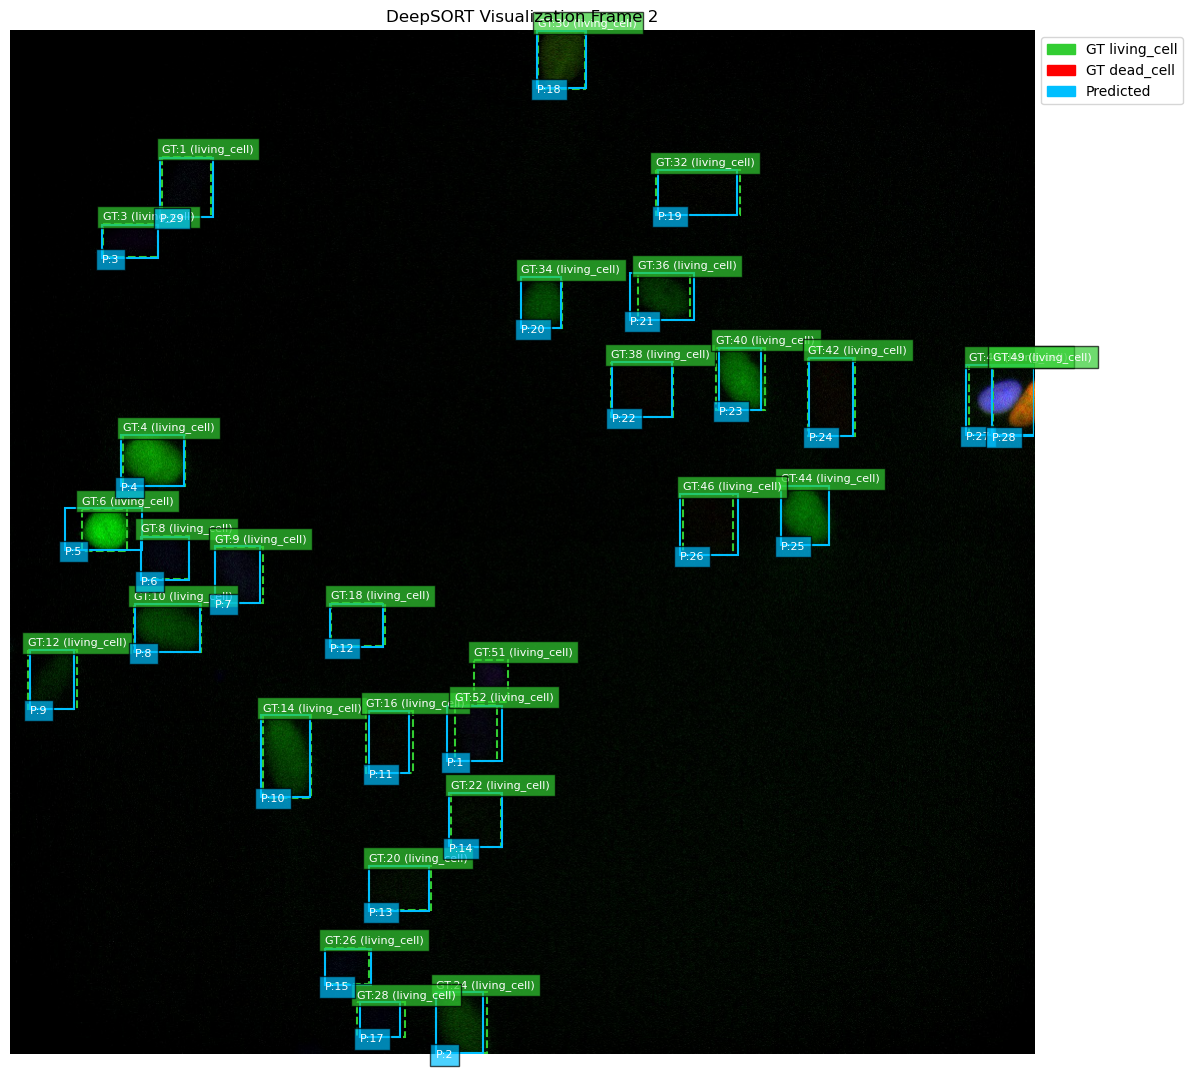

In [136]:
# Visualize one example with the ground truth and predicted bounding boxes
# Rebuild for video "003"
video_image_infos = [
    img for img in img_by_id.values()
    if img["file_name"].startswith("003/")
]
video_image_infos.sort(key=lambda x: x["frame_id"])
# Pick a frame
viz_info = video_image_infos[2]
frame_no = viz_info['frame_id']
# Load the correct results.txt
dets = np.loadtxt("output/003/results.txt", delimiter=',')
# Filter for that frame
frame_preds = [p for p in dets if int(p[0]) == frame_no]
# Build example_frame_data
example_frame_data = {
    'image_path': DATASET_DIR / viz_info['file_name'],
    'gt_bboxes': [], 'gt_ids': [], 'gt_categories': [],
    'pred_bboxes': [], 'pred_ids': []
}
# Populate ground truth (center → corners)
for ann in annots_by_img[viz_info['id']]:
    x_center, y_center, width, height = ann['bbox']
    x1, y1 = x_center - width/2, y_center - height/2
    example_frame_data['gt_ids'].append(ann['cell_id'])
    example_frame_data['gt_bboxes'].append([x1, y1, x1 + width, y1 + height])
    example_frame_data['gt_categories'].append(ann['category_id'])
# Populate predictions (top-left → corners)
for frame, tid, vid, x, y, width, height, *_ in frame_preds:
    x1 = x
    y1 = y
    x2 = x + width
    y2 = y + height
    example_frame_data['pred_ids'].append(int(tid))
    example_frame_data['pred_bboxes'].append([x1, y1, x2, y2])
# Draw exactly the selected frame
img = Image.open(example_frame_data['image_path']).convert("RGB")
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(img); ax.axis('off')
# Draw ground truth bounding boxes (dashed)
for (x1,y1,x2,y2), gid, cid in zip(
        example_frame_data['gt_bboxes'],
        example_frame_data['gt_ids'],
        example_frame_data['gt_categories']):
    col = CATEGORY_COLORS[cid]['color']
    nm  = CATEGORY_COLORS[cid]['name']
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                             linewidth=1.5, edgecolor=col,
                             facecolor='none', linestyle='--')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f"GT:{gid} ({nm})",
            bbox=dict(facecolor=col, alpha=0.7),
            color='white', fontsize=8)
# Draw predicted bounding boxes
for (x1,y1,x2,y2), pid in zip(
        example_frame_data['pred_bboxes'],
        example_frame_data['pred_ids']):
    rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                             linewidth=1.5, edgecolor=PRED_COLOR,
                             facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y2+5, f"P:{pid}",
            bbox=dict(facecolor=PRED_COLOR, alpha=0.7),
            color='white', fontsize=8)
# Show legend and title
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1,1), fontsize=10)
plt.title(f"DeepSORT Visualization Frame {frame_no}")
plt.tight_layout()
plt.show()

In [162]:
def get_frame_example(vid_name, frame_no, annots_by_img, img_by_id, all_dets):
    """
    get_frame_example retrieves the ground truth and prediction data for a specific frame.

    :param vid_name: the video name (e.g. "001") the frame belongs to
    :param frame_no: the frame number (time step)
    :param annots_by_img: annotations grouped by their image ID
    :param img_by_id: images grouped by their ID
    :param all_dets: a stacked array with tracklets from all results.txt files across the test folders
    
    :return: a dictionary containing image path, ground truth boxes/IDs/categories, and predicted boxes/IDs
    """ 
    # Find the image metadata for the given video and frame number
    imgs = [
        img for img in img_by_id.values()
        if img["file_name"].startswith(vid_name + "/") and img["frame_id"] == frame_no
    ]
    # Get the first image (to be used for visualization of first special event)
    info = imgs[0]
    # Get the predictions for this frame
    frame_preds = [r for r in all_dets if int(r[0]) == frame_no]
    # Initialize the dictionary for this frame
    ex = {
        'image_path': DATASET_DIR / info["file_name"],
        'gt_bboxes': [], 'gt_ids': [], 'gt_categories': [],
        'pred_bboxes': [], 'pred_ids': []
    }
    # Loop through the ground truth annotations and add the IDs, categories and bounding boxes to the dictionary
    for ann in annots_by_img[info["id"]]:
        x_center, y_center, width, height = ann["bbox"]
        x1, y1 = x_center - width / 2, y_center - height / 2
        ex['gt_ids'].append(ann['cell_id'])
        ex['gt_categories'].append(ann['category_id'])
        ex['gt_bboxes'].append([x1, y1, x1 + width, y1 + height])
    # Loop through the predicted annotations and add the IDs and bounding boxes to the dictionary
    for _, tid, vid, x, y, width, height, *_ in frame_preds:
        ex['pred_ids'].append(int(tid))
        ex['pred_bboxes'].append([x, y, x + width, y + height])
    return ex

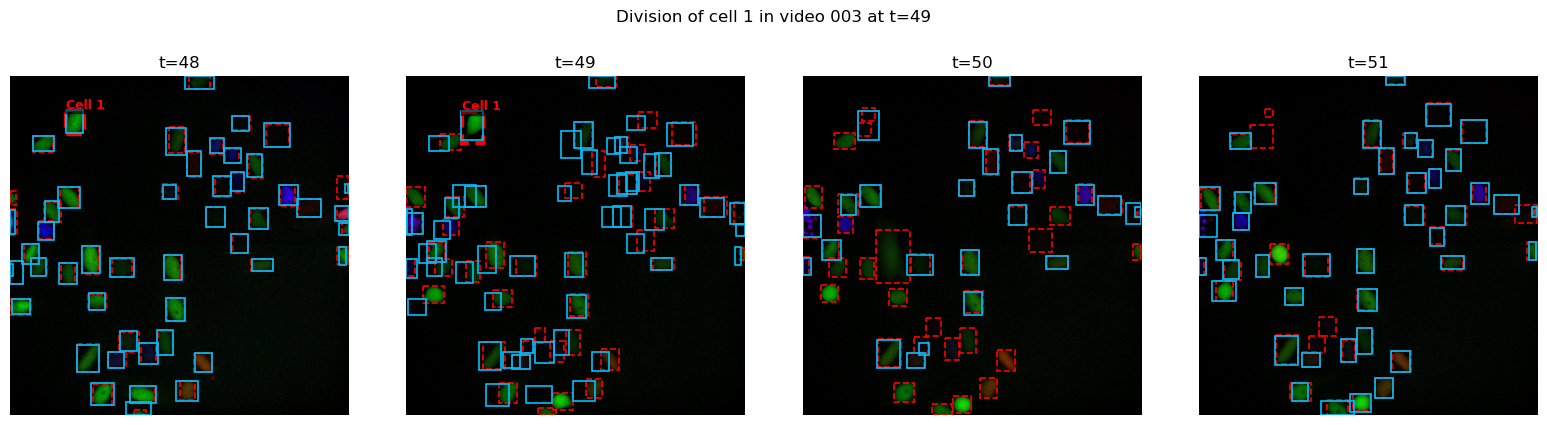

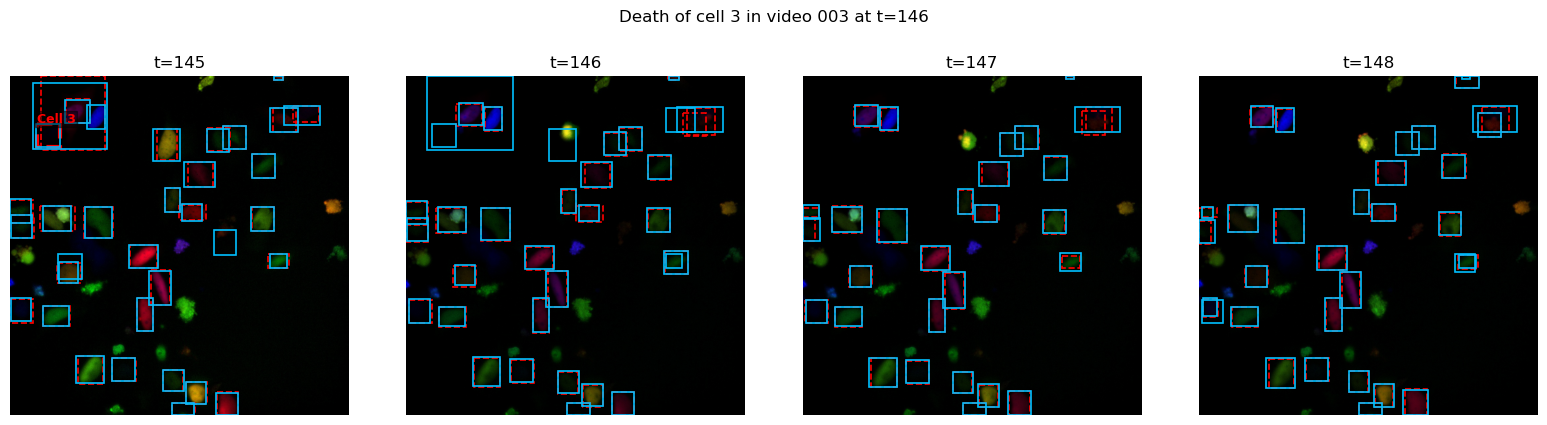

In [183]:
# Show a sequence of images to visualize how DeepSORT behaves during a cell division and cell death
# Load the stacked array with tracklets from all results.txt files across the test folders
all_results = load_all_results(test_folders, base_dir="output")
# Pick first example each for cell division and cell death
chosen = {}
# Loop through the array of special events to find the first example of a cell division and cell death
for vid_name, t_event, cellid, evtype in events:
    # Skip if the current video is not a test folder
    if vid_name not in test_folders:
        continue
    # If cell division has not yet been added to chosen, add this special event, else skip
    # If cell dead has not yet been added to chosen, add this special event, else skip
    if evtype not in chosen:
        chosen[evtype] = (vid_name, t_event, cellid)
    # Break the loop if two special events (one cell division, one cell death) have been added to chosen
    if len(chosen) == 2:
        break
# Visualize both special events
for evtype, (vid_name, t_event, cellid) in chosen.items():
    # Specify a sequence of four images around the special event frame
    frames = list(range(max(0, t_event - 1), t_event + 3))
    fig, axes = plt.subplots(1, len(frames), figsize=(4 * len(frames), 4))
    fig.suptitle(f"{evtype.title()} of cell {cellid} in video {vid_name} at t={t_event}", y=1.05)
    # Retrieve the ground truth and prediction data for the specific frames
    for ax, fn in zip(axes, frames):
        ex = get_frame_example(vid_name, fn, annots_by_img, img_by_id, all_results)
        if ex is None:
            ax.axis('off')
            continue
        # Open the image for the specific frame and convert to RGB
        img = Image.open(ex['image_path']).convert("RGB")
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"t={fn}")
        # Draw ground truth bounding boxes (dashed)
        for (x1, y1, x2, y2), gid, cid in zip(ex['gt_bboxes'], ex['gt_ids'], ex['gt_categories']):
            is_event_cell = gid == cellid
            col = 'red'
            lw = 3 if is_event_cell else 1.2
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=lw, edgecolor=col,
                                     facecolor='none', linestyle='--')
            ax.add_patch(rect)
            # Specifically mark the cell that gets divided or dies
            if is_event_cell:
                ax.text(x1, y1 - 5, f"Cell {gid}", fontsize=9, color=col,
                        fontweight='bold', bbox=dict(facecolor='black', alpha=0.5, pad=1))
        # Draw predicted bounding boxes
        for (x1, y1, x2, y2), pid in zip(ex['pred_bboxes'], ex['pred_ids']):
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=1.2, edgecolor=PRED_COLOR,
                                     facecolor='none')
            ax.add_patch(rect)
    plt.tight_layout()
    plt.show()